# Implementation of Monte Carlo ES (Exploring Starts) on FrozenLake-v1

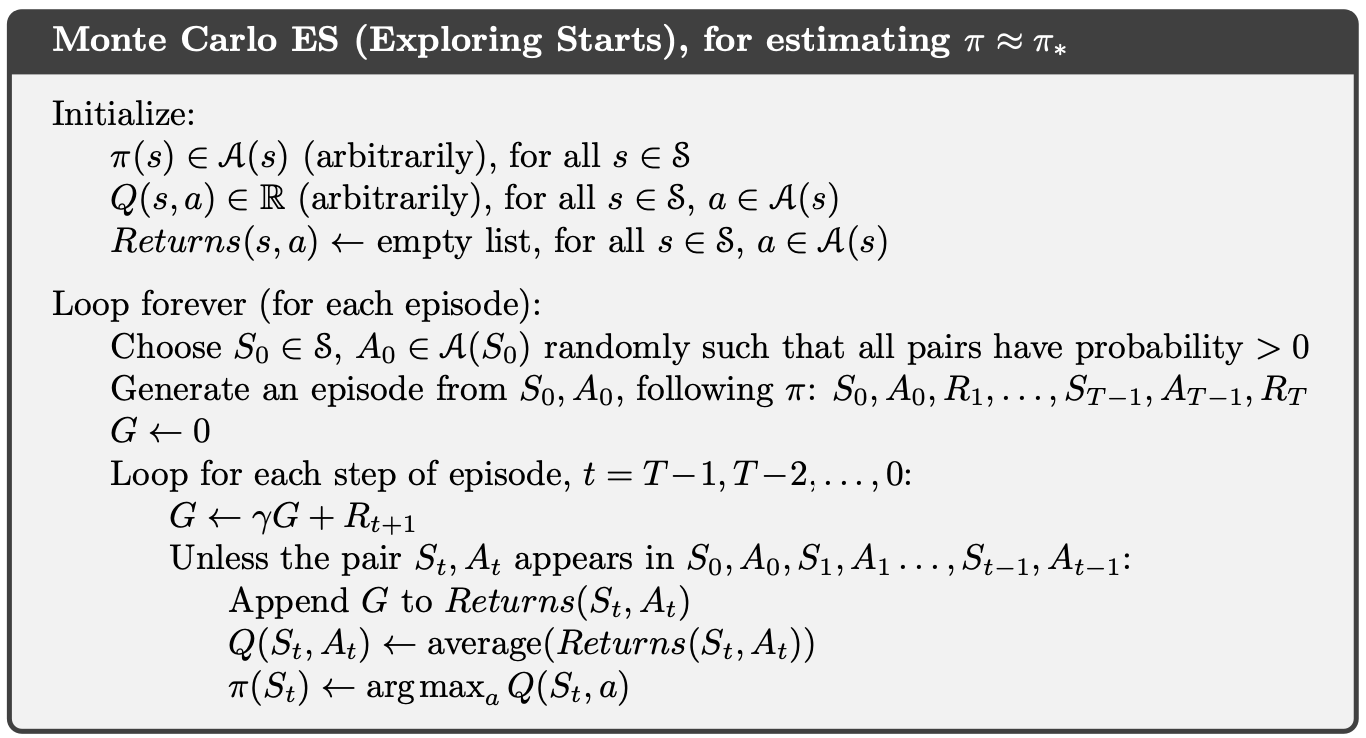

Implemeting Exploring Starts MC on FrozenLake is not optimal as first question is that there isn't a randomized starting state that you can have. In this game, the only starting state is in the top left corner or any specific position. In addition, there seems to be issue with when you choose a random action such as going down and then the next time the random action is going right then the policy changes. 

In [71]:
import gym
import numpy as np

# Parameters
custom_map = [
    'SFFF',
    'FFFH',
    'FFFH',
    'HFFG',
]
env = gym.make("FrozenLake-v1", desc=custom_map, is_slippery=False, render_mode="human")
nS = env.observation_space.n 
nA = env.action_space.n 
gamma = 0.90
maxEpisodes = 100

# Initialization
Q = np.zeros([nS, nA])
returns = [[[] for _ in range(nA)] for _ in range(nS)]
policy = np.random.randint(0, nA, nS, dtype=int) # Generate a random policy

# Loop Forever
for episode in range(maxEpisodes):
    # Choose State and Action Randomly
    s0 = np.random.randint(0,nS, 1, dtype=int) # The initial state is always the same in the game
    a0 = np.random.randint(0,nA, 1, dtype=int)

    # Generate episode from the first initial State and initial Action
    done = False
    currentStepOfEpisode = 0
    initialState, _ = env.reset()
    trajectory = []
    while not done:
        # Determine the action to take
        action = None
        if currentStepOfEpisode == 0:
            action = a0[0]
        else:
            action = policy[currentStepOfEpisode]

        nextState, reward, done, _, _ = env.step(action)

        # If the agent is still on ice, then give penalty for not finding the treasure.
        if reward == 0:
            reward = -0.001
        
        # If the agent falls into the hole, give a large penalty
        if done and nextState != 15:
            reward = -2
        
        # If agent took too long, penalize
        if currentStepOfEpisode == nS-1:
            done = True
            reward = -1
        
        # Penalize if agent doesnt move
        if initialState == nextState:
            reward = -1
        
        # If Aget found the goal
        if done and nextState == 15:
            reward = 3

        trajectory.append([initialState, action, reward])
        initialState = nextState
        currentStepOfEpisode += 1

    # Loop through each step of the episode but in reverse
    trajectory.reverse()
    stateActionPair = np.array([[entry[0], entry[1]] for entry in trajectory])
    G = 0
    for step in range(len(trajectory)):
        G = gamma * G + trajectory[step][2]
        if [trajectory[step][0],trajectory[step][1]] not in stateActionPair[step+1:][step+1:]:
            returns[trajectory[step][0]][trajectory[step][1]].append(G)
            Q[trajectory[step][0]][trajectory[step][1]] = sum(returns[trajectory[step][0]][trajectory[step][1]]) / len(returns[trajectory[step][0]][trajectory[step][1]])
            print(Q)
            print(policy)
            policy[len(trajectory)-step] = np.random.choice(np.where(Q[step] == Q[step].max())[0])
            # policy[step] = np.argmax(Q[step])

[[ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [-1.46071  0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]]
[3 3 2 1 1 0 2 1 0 0 3 3 3 0 1 0]
[[ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.       -1.315639  0.        0.      ]
 [ 0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.     

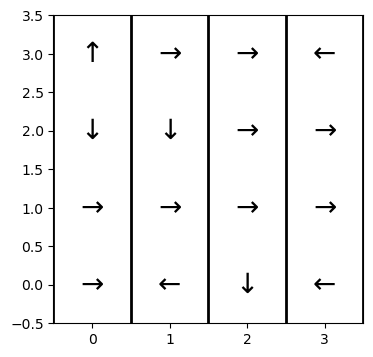

In [72]:
# Visualize the Policy
import matplotlib.pyplot as plt

def actionToArrow(action):
    if action == 0:
        return '←'
    elif action == 1:
        return '↓'
    elif action == 2:
        return '→'
    elif action == 3:
        return '↑'

nrow, ncol = 4, 4

fig, ax = plt.subplots(figsize=(ncol, nrow))
ax.set_xticks(np.arange(ncol+1)-0.5, minor=True)
ax.set_yticks(np.arange(nrow+1)-0.5, minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
ax.tick_params(which="minor", size=0)
ax.set_xlim(-0.5, ncol-0.5)
ax.set_ylim(-0.5, nrow-0.5)
for i in range(nrow):
    for j in range(ncol):
        action = policy[i*ncol + j]
        arrow = actionToArrow(action)
        ax.text(j, nrow-1-i, arrow, ha='center', va='center', fontsize=20)
plt.show()
env.close()

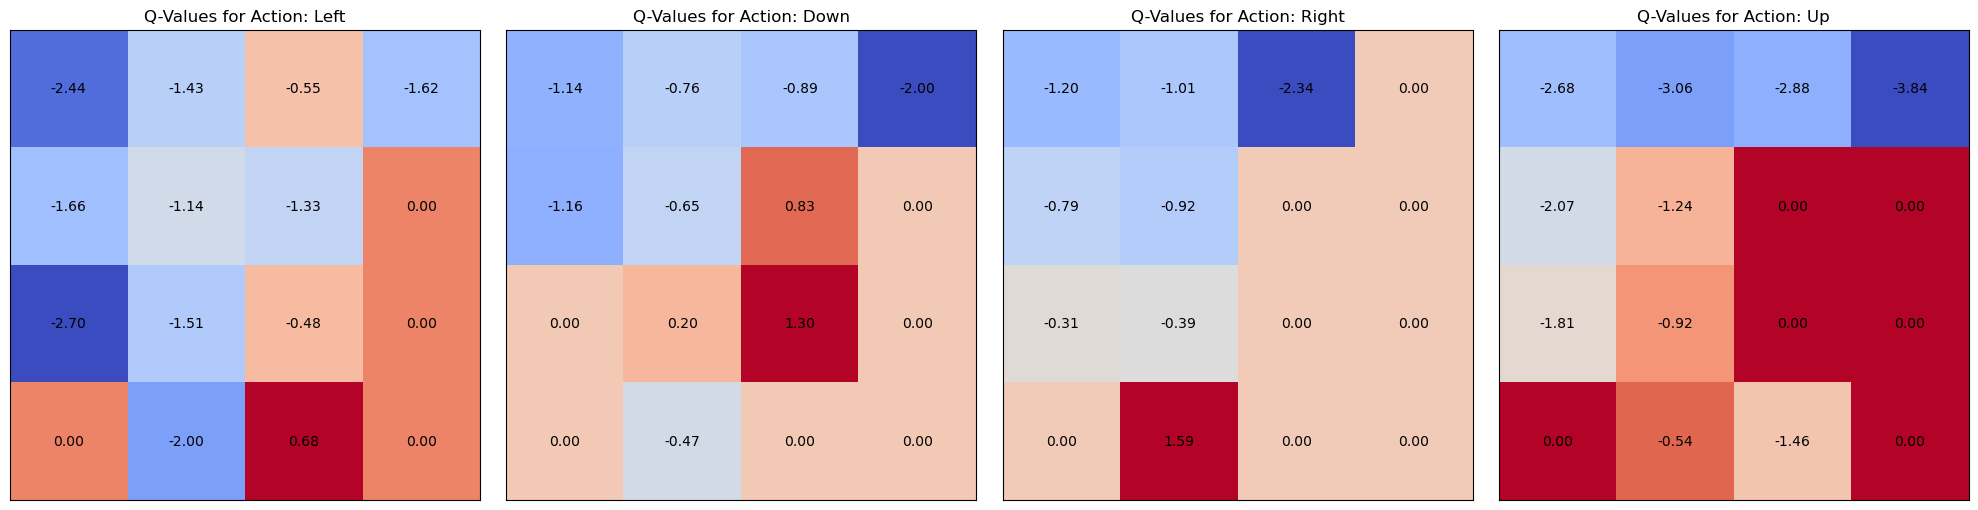

In [79]:
# Visualize State Values as a Heatmap
fig, axes = plt.subplots(1, nA, figsize=(20, 5))
actions = ["Left", "Down", "Right", "Up"]

for i in range(nA):
    Q_action = Q[:, i].reshape((4, 4))
    ax = axes[i]
    cax = ax.matshow(Q_action, cmap="coolwarm")
    for (j, k), val in np.ndenumerate(Q_action):
        ax.text(k, j, f'{val:.2f}', ha='center', va='center', color='black')
    ax.set_title(f'Q-Values for Action: {actions[i]}')
    ax.set_xticks([])
    ax.set_yticks([])

# fig.colorbar(cax, ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
plt.tight_layout()
plt.show()

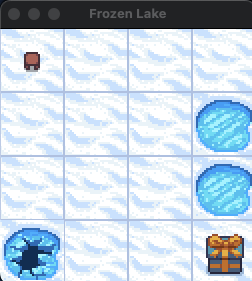

This is the layout of the map. As we can tell, the policy generated is not optimal especially on as in the Q value in the top left corner. In general, On Policy First Visit MC Method is not the quickest method to find convergence in this problem space. A better example of utilizing On Policy First Visit MC Method is through blackjack. The rate of covergence through this algorithm is lower than other algorithms as our initial policy is random. It is only when the policy finds the treasure is when we can converge faster.